# `shapely`对矢量数据的处理(1)

In [1]:
import shapely; 
import shapely.geometry as shpgeo; 

## `shapely.geometry`中的几何图形对象

### 单点(`Point`)和多点(`MultiPoint`)对象
构造方法
* 单点或多点对象通过声明每个点在**直角坐标系**中的坐标得到
    * 因此, 如果需要使用`shapely`处理GIS中的矢量数据, 需要**为数据指定适当的投影坐标系**
* 多点对象可通过不同的单点对象取并集(联合叠置分析)得到

POINT (1 0) POINT (0 1) POINT (0 0)
MULTIPOINT (1 0, 0 1, 0 0)


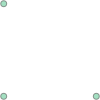

In [2]:
#定义三角形ΔABC的三个顶点, 显然C是直角顶点
vertex_coord = ((1, 0), (0, 1), (0, 0)); 
A, B, C = tuple(shpgeo.Point(x, y) for x, y in vertex_coord); 
verteces = shpgeo.multipoint.MultiPoint(vertex_coord); 
print(A, B, C); print(verteces); 
verteces

多点对象的有序性
* 打乱多点对象中点的先后顺序构造新的多点对象后: 
    * 新对象与原对象使用`==`进行比较将返回`False`, 
    * 但如调用`equals`方法, 则返回`True`. 

In [3]:
print(A.union(B).union(C) == verteces); 
print(A.union(C).union(B) == verteces); 
print(A.union(C).union(B).equals(verteces)); 

False
False
True


### 折线(`Linestring`)和闭合折线(`LinearRing`)对象
构造方法
* 通过声明其**顺次连接**的每个点的坐标得到
* 根据多点对象转换得到
* 如果要求`LineString`折线闭合, 需要将首个点的信息复制并添加至坐标序列尾部

In [4]:
multiSegABC = shpgeo.LineString(verteces); #此时得到的折线ABC仅包含线段AB和BC
multiSegACB = shpgeo.LineString(
    tuple(verteces[idx] for idx in (0, 2, 1))
);  #此时得到的折线ACB仅包含线段AC和CB, 因为是按照A, C, B的顺序取顶点组成tuple
closedSegABC = shpgeo.LinearRing(verteces); 
print(multiSegABC, multiSegACB, closedSegABC, sep='\n'); 

LINESTRING (1 0, 0 1, 0 0)
LINESTRING (1 0, 0 0, 0 1)
LINEARRING (1 0, 0 1, 0 0, 1 0)


### 多边形(`polygon`)对象
构造方法
* 需要指定多边形的外边界, 若多边形内部存在孔洞, 还需要指定内边界
* 声明其内, 外边界**顺次连接**的每个点的坐标得到; 
* 根据多点, 折线对象转换得到; 

多边形的有效性
* 有效的条件: 
    * 外边界和内边界(如果指定)的顶点数量不少于3个; 
    * 任何一条边**除端点外的部分**, 不得与其他边存在公共点; 
    * 多边形除顶点和边以外的部分, 处在同一个连通分支内
* 多边形无效时, 部分属性或方法无法正常调用. 
* 多边形有效与否的状态值可通过`is_valid`属性获取; 
* 将无效多边形转化为有效多边形的方式, 主要调用`buffer`属性, 并设置缓冲长度为0

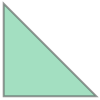

In [5]:
triangleABC = shpgeo.Polygon(verteces); 
triangleACB = shpgeo.Polygon(multiSegACB); 
triangleABC

多边形端点的有序性
* 与多点, 折线对象类似, 多边形对象的顶点也是有序的
    * 但调换多边形的方向, 所得的新多边形面积并不会变号, \
      因为`polygon`对象的`area`属性, 计算的是无向多边形的面积

In [6]:
print(triangleABC == triangleACB, triangleABC.equals(triangleACB))
print(triangleABC.area, triangleACB.area)

False True
0.5 0.5


## `shapely.geometry`几何对象的属性

### 位置信息
|方法名称|功能|备注|
|:-|:-:|:-|
|`coords`|提取几何图形的每个<br>组件的坐标信息||
|`centroid`|计算几何中心点||
|`bounds`|计算图形各坐标<br>分量的最小(大)值||
|`envelope`|计算外接矩形<br>或外接立方体|外接矩形(立方体)的边(棱, 面)<br>平行于坐标轴或坐标平面, <br>可用于提高空间查询效率|
|`minimum_rotated`<br>`_rectangle`|计算最小外接<br>矩形(立方体)|长宽(高)比例和长边方向<br>可大致反映图形的形状和朝向|
|`convex_hull`|计算最小外接凸<br>多边形或凸多面体|衡量多边形边缘的复杂度|

In [7]:
geomt = [verteces, multiSegABC, multiSegACB, triangleABC]; 

In [8]:
geomt_Cent = [shp.centroid for shp in geomt]; 
[print(shp.coords.xy) for shp in geomt_Cent]; 

(array('d', [0.3333333333333333]), array('d', [0.3333333333333333]))
(array('d', [0.29289321881345254]), array('d', [0.5]))
(array('d', [0.25]), array('d', [0.25]))
(array('d', [0.3333333333333333]), array('d', [0.3333333333333333]))


In [9]:
#分别构造上述几何图形的外接矩形, 最小外接矩形, 最小外接凸多边形
geomt_Envl = [shp.envelope for shp in geomt]; 
geomt_RotEnvl = [shp.minimum_rotated_rectangle for shp in geomt]; 
geomt_Convex = [shp.convex_hull for shp in geomt]; 

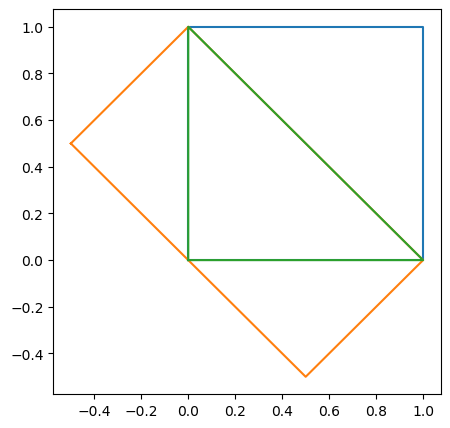

In [10]:
#绘图比较三种外接多边形的范围
import matplotlib.pyplot as plt; 
plt.subplots(figsize=(5, 5)); 
for polygon in list(zip(geomt_Envl, geomt_RotEnvl, geomt_Convex))[0]: 
    x, y = polygon.boundary.xy; 
    plt.plot(x, y); 
plt.show(); 

### 形状信息
|方法名称|功能|备注|
|:-|:-:|:-|
|`is_closed`|判断折线是否闭合|终点与起点重合|
|`is_ring`|判断折线是否成环|终点与起点重合, **同时**任何<br>一条边除端点外的部分, 不得<br>与其他边存在公共点|
|`booundary`|计算折线的起终点或<br>多边形的所有边界|对于`Point`, `MultiPoint`<br>或`LinearRing`对象, <br>该方法的返回值为不包含<br>任何要素的几何对象|
|`exterior`|返回多边形的外部边界||
|`interiors`|返回多边形所有<br>孔洞边界的列表||

In [11]:
cmplx_Polygon = geomt_Envl[0].union(geomt_RotEnvl[0]); 
cmplx_Polygon = shpgeo.Polygon(cmplx_Polygon.boundary, holes=[triangleABC.boundary]); 

In [12]:
cmplx_bnd = cmplx_Polygon.boundary; 
cmplx_ext = cmplx_Polygon.exterior; 
cmplx_int = cmplx_Polygon.interiors[0]; 
print(cmplx_bnd, cmplx_ext, cmplx_int, sep='\n'); 

MULTILINESTRING ((0 0.9999999999999998, 0 1, 1 1, 1 0, 0.9999999999999998 0, 0.4999999999999999 -0.4999999999999999, 0 0, -0.4999999999999999 0.4999999999999999, 0 0.9999999999999998), (1 0, 0 1, 0 0, 1 0))
LINEARRING (0 0.9999999999999998, 0 1, 1 1, 1 0, 0.9999999999999998 0, 0.4999999999999999 -0.4999999999999999, 0 0, -0.4999999999999999 0.4999999999999999, 0 0.9999999999999998)
LINEARRING (1 0, 0 1, 0 0, 1 0)


### 大小信息
|方法名称|功能|备注|
|:-|:-:|:-|
|`length`|计算折线或多边形<br>边界的全长|对于`Point`或`MultiPoint`对象, <br>该方法的返回值始终为0. |
|`area`|计算多边形的面积|对于`Point`, `MultiPoint`, <br>`LineString`或`LinearRing`对象, <br>该方法的返回值始终为0. |

In [13]:
import decimal as deci; from decimal import Decimal; 
deci.setcontext(deci.Context(prec=6, rounding=deci.ROUND_HALF_EVEN)); 
[print(Decimal(str(shp.length)).fma(1, 0), 
    Decimal(str(shp.area)).fma(1, 0), 
    sep='\t') \
    for shp in (A, multiSegABC, triangleABC)];

0.0	0.0
2.41421	0.0
3.41421	0.5
